## QCNN implementation

In [1]:
import matplotlib.pyplot as plt
from torchquantum.plugins import op_history2qasm
from source.models import *
from source.state_prep import *
from source.train_funcs import *

### Calling model and training

In [2]:
circuit_builder = MajoranaCircuit
model = QCNNBase(circuit_builder)
train_load, train_lab, test_load, test_lab = generate_data(model, n_points=200)
model, preds = train(model, train_load,train_lab)

  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 0, loss: 0.3979726731777191
epoch: 1, loss: 0.5378084778785706
epoch: 2, loss: 0.5965042114257812
epoch: 3, loss: 0.5094445943832397
epoch: 4, loss: 0.34552520513534546
epoch: 5, loss: 0.2142472267150879
epoch: 6, loss: 0.13971427083015442
epoch: 7, loss: 0.0982278510928154
epoch: 8, loss: 0.07516473531723022
epoch: 9, loss: 0.06192011013627052


### Testing the trained model

In [3]:
preds, accuracy = test(model, test_load, test_lab)
print(accuracy)

0.9166666666666666


### Plot results and visualize phase diagram

Text(0.5, 1.0, 'QCNN classification (1 = trivial, 0 = topological)')

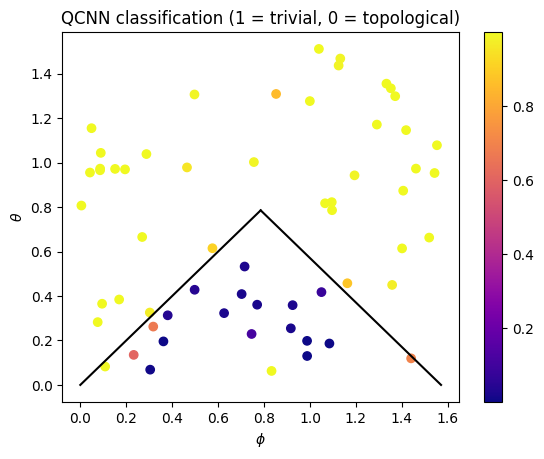

In [4]:
f, ax = plt.subplots()
phis = []
thetas = []
pred_s = []
for i, angles in enumerate(test_load):
    pred = preds[i].detach().numpy()
    theta = angles[0].detach().numpy()
    phi = angles[1].detach().numpy()
    phis.append(phi)
    thetas.append(theta)
    pred_s.append(pred)

points = ax.scatter(phis, thetas, c=pred_s,cmap='plasma')
f.colorbar(points)
ax.plot(np.linspace(0, np.pi/4, 50), np.linspace(0, np.pi/4, 50), c = 'k')
ax.plot(np.linspace(np.pi/4, np.pi/2, 50), np.ones(50)*np.pi/2-np.linspace(np.pi/4, np.pi/2, 50), c = 'k')
ax.set_xlabel(r'$\phi$')
ax.set_ylabel(r'$\theta$')
ax.set_title('QCNN classification (1 = trivial, 0 = topological)')

In [5]:
# qiskit_circuit = op_history2qasm(qdev.n_wires, qdev.op_history)